In [48]:
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
# import the relevant Keras modules
from keras.models import Sequential,Model
from keras.layers import Activation, Dense, Input
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def preprocess_lstm(df):
    data_x = []
    for i in range(len(df)-window_len):
        temp_set = df[i:(i+window_len)].copy()
        data_x.append(temp_set)
    data_x = [np.array(x) for x in data_x]
    data_x = np.array(data_x)
    return data_x

def build_model(inputs, output_size, neurons, activ_func="linear",dropout=0.1, loss="mse", optimizer="adam"):
    model = Sequential()
    model.add(CuDNNLSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]),return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout))
    model.add(CuDNNLSTM(neurons))
    model.add(Dropout(dropout))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [50]:
df = pd.read_pickle("/home/filip/Desktop/Ruđer/FinalData/general.pkl")
df = df.tail(100000).reset_index(drop=True)
df = df.drop(columns="Timestamp")
print(df.columns)
df.head()

Index(['High_x', 'Low_x', 'Trades_x', 'Std_x', 'Weighted_Price_x', 'Open_x',
       'Close_x', 'Volume_x', 'Dolars_x', 'Denoised_Price_1_Weighted_Price_x',
       'Denoised_Price_2_Weighted_Price_x', 'Price_Change_Weighted_Price_x',
       'Denoised_Price_Change_Weighted_Price_x', 'Denoised_Price_1_Open_x',
       'Denoised_Price_2_Open_x', 'Price_Change_Open_x',
       'Denoised_Price_Change_Open_x', 'Denoised_Price_1_Close_x',
       'Denoised_Price_2_Close_x', 'Price_Change_Close_x',
       'Denoised_Price_Change_Close_x', 'Denoised_Price_1_Dolars_x',
       'Denoised_Price_2_Dolars_x', 'Price_Change_Dolars_x',
       'Denoised_Price_Change_Dolars_x', 'High_y', 'Low_y', 'Trades_y',
       'Std_y', 'Weighted_Price_y', 'Open_y', 'Close_y', 'Volume_y',
       'Dolars_y', 'Denoised_Price_1_Weighted_Price_y',
       'Denoised_Price_2_Weighted_Price_y', 'Price_Change_Weighted_Price_y',
       'Denoised_Price_Change_Weighted_Price_y', 'Denoised_Price_1_Close_y',
       'Denoised_Price_2_Cl

,High_x,Low_x,Trades_x,Std_x,Weighted_Price_x,Open_x,Close_x,Volume_x,Dolars_x,Denoised_Price_1_Weighted_Price_x,...,Price_Change_Close_y,Denoised_Price_Change_Close_y,Denoised_Price_1_Open_y,Denoised_Price_2_Open_y,Price_Change_Open_y,Denoised_Price_Change_Open_y,Denoised_Price_1_Dolars_y,Denoised_Price_2_Dolars_y,Price_Change_Dolars_y,Denoised_Price_Change_Dolars_y
0,6399.99,6399.98,10.0,0.005166,6399.986000,6399.98,6399.98,0.848476,5430.231222,6399.987444,...,-0.000294,0.000000,6400.385,6400.6925,0.000195,0.000000,35481.159785,20317.334575,-0.969448,0.000000
1,6400.00,6399.98,18.0,0.004712,6399.988889,6399.99,6399.99,1.707264,10926.471439,6399.987444,...,0.000003,-0.000144,6401.000,6400.6925,-0.000002,0.000096,5153.509366,20317.334575,1.065481,-0.854754
2,6399.99,6399.98,12.0,0.004524,6399.987500,6399.98,6399.99,0.626308,4008.364041,6399.986477,...,0.000000,0.000000,6401.000,6400.6925,0.000000,0.000000,5153.509366,20317.334575,0.371975,0.000000
3,6399.99,6399.98,11.0,0.005223,6399.985455,6399.99,6399.99,0.677248,4334.380620,6399.986477,...,0.000000,0.000298,6401.000,6402.0350,0.000000,0.000000,21102.027193,67868.342600,2.672671,3.094691
4,6399.99,6399.98,10.0,0.005166,6399.986000,6399.99,6399.98,0.543781,3480.190212,6399.987063,...,0.000595,0.000000,6401.000,6402.0350,0.000000,0.000000,21102.027193,67868.342600,-0.072462,0.000000


In [66]:
window_len = 2
test_split = 0.10
val_split = 0.10
output_index = "Price_Change_Close_y"
training_set = df[df.index < (df.shape[0]*(1-test_split-val_split))]
val_set = df[(df.index >= df.shape[0]*(1-test_split-val_split))&(df.index<(df.shape[0]*(1-test_split)))]
test_set = df[df.index >= df.shape[0]*(1-test_split)]

In [69]:
LSTM_training_outputs = pd.DataFrame(training_set[output_index][window_len:].values)
LSTM_test_outputs = pd.DataFrame(test_set[output_index][window_len:].values)
LSTM_val_outputs = pd.DataFrame(val_set[output_index][window_len:].values)

In [70]:
LSTM_training_inputs = preprocess_lstm(training_set)
LSTM_test_inputs = preprocess_lstm(test_set)
LSTM_val_inputs = preprocess_lstm(val_set)

In [73]:
cb = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=0, 
                   mode='auto')

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)

In [74]:
with tf.device("/gpu:0"):
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=5, batch_size=32, verbose=True, validation_data=(LSTM_val_inputs, LSTM_val_outputs),callbacks=[cb,mc])

Train on 79998 samples, validate on 9998 samples
Epoch 1/5
79998/79998 [==============================] - 21s 261us/step - loss: 5.3754e-05 - val_loss: 2.8028e-06
Epoch 2/5
79998/79998 [==============================] - 19s 239us/step - loss: 3.1162e-06 - val_loss: 2.4290e-06
Epoch 3/5
79998/79998 [==============================] - 22s 277us/step - loss: 2.0710e-06 - val_loss: 2.5338e-06
Epoch 4/5
79998/79998 [==============================] - 20s 254us/step - loss: 1.8474e-06 - val_loss: 2.4318e-06
Epoch 5/5
79998/79998 [==============================] - 25s 318us/step - loss: 1.8229e-06 - val_loss: 2.3458e-06


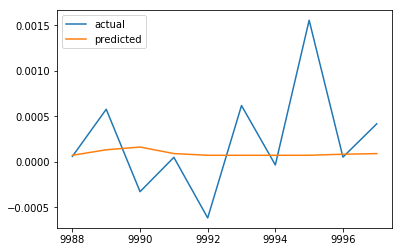

The Mean Absolute Error is: 0.0007572008628485156


In [75]:
plt.plot(LSTM_test_outputs.tail(10), label = "actual")
plt.plot(pd.DataFrame(nn_model.predict(LSTM_test_inputs)).tail(10), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))